In [14]:
import numpy as np
import json
import os

import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
import xarray as xr

from utils_mitgcm import open_mitgcm_ds_from_config


In [2]:
model = 'geneva_200m'

In [3]:
str_start_time = "2023-07-01T12:00:00.000000000"
str_end_time = "2023-07-17T00:00:00.000000000"

depth_index=8

outputpath = "../99-Outputs/nencioli/"

# Open MITgcm results

In [4]:
mitgcm_config, xr_mitgcm = open_mitgcm_ds_from_config('../config.json', model)

# Compute streamlines

In [32]:
import numpy as np

def stream2_dc(x, y, u, v, startx, starty, dr=0.1, N=10000):
    X = np.full(N, np.nan)
    Y = np.full(N, np.nan)
    X[0] = startx
    Y[0] = starty

    dx = x - startx
    dy = y - starty
    d = dx**2 + dy**2
    j = np.nanargmin(d)
    row, col = np.unravel_index(j, x.shape)

    for i in range(1, N):
        try:
            x1 = x[row, col]
            y1 = y[row, col]
            u1 = u[row, col]
            v1 = v[row, col]

            row2 = row + (1 if startx > x1 else -1)
            col2 = col + (1 if starty > y1 else -1)

            if (row2 < 0 or row2 >= x.shape[0] or
                col2 < 0 or col2 >= x.shape[1]):
                break

            x2, y2 = x[row2, col], y[row2, col]
            x3, y3 = x[row, col2], y[row, col2]
            x4, y4 = x[row2, col2], y[row2, col2]

            u2, v2 = u[row2, col], v[row2, col]
            u3, v3 = u[row, col2], v[row, col2]
            u4, v4 = u[row2, col2], v[row2, col2]

            r1 = np.hypot(startx - x1, starty - y1)
            r2 = np.hypot(startx - x2, starty - y2)
            r3 = np.hypot(startx - x3, starty - y3)
            r4 = np.hypot(startx - x4, starty - y4)

            if r1 == 0:
                u0, v0 = u1, v1
            elif r2 == 0:
                u0, v0 = u2, v2
            elif r3 == 0:
                u0, v0 = u3, v3
            elif r4 == 0:
                u0, v0 = u4, v4
            else:
                weights = []
                values_u = []
                values_v = []

                for r, uu, vv in zip([r1, r2, r3, r4],
                                     [u1, u2, u3, u4],
                                     [v1, v2, v3, v4]):
                    if np.isnan(uu):
                        weights.append(0)
                        values_u.append(0)
                        values_v.append(0)
                    else:
                        weights.append(1/r)
                        values_u.append(uu/r)
                        values_v.append(vv/r)

                norm = sum(weights)
                if norm == 0:
                    break
                u0 = sum(values_u) / norm
                v0 = sum(values_v) / norm

            U = np.hypot(u0, v0)
            if U == 0:
                break
            ddx = abs(x2 - x1)
            dt = ddx / U * dr

            startx += dt * u0
            starty += dt * v0
            X[i] = startx
            Y[i] = starty

            # Update grid cell
            r1 = np.hypot(startx - x1, starty - y1)
            r2 = np.hypot(startx - x2, starty - y2)
            r3 = np.hypot(startx - x3, starty - y3)
            r4 = np.hypot(startx - x4, starty - y4)

            if r2 < r1 and r2 < r3 and r2 < r4:
                row = row2
            elif r3 < r1 and r3 < r2 and r3 < r4:
                col = col2
            elif r4 < r1 and r4 < r2 and r4 < r3:
                row = row2
                col = col2

        except Exception:
            break

    return X, Y

In [33]:
t_index = 0
z_index = 0

In [36]:
X2D, Y2D = np.meshgrid(xr_mitgcm['XC'].values, 
                       xr_mitgcm['YC'].values, 
                       indexing='ij')  # shape (336, 132)

In [41]:
X, Y = stream2_dc(
    x=X2D,
    y=Y2D,
    u=xr_mitgcm['UVEL'].isel(time=t_index, Z=z_index).values,
    v=xr_mitgcm['VVEL'].isel(time=t_index, Z=z_index).values,
    startx=30000.0,  # choose appropriate point in domain
    starty=15000.0
)

In [42]:
X

array([30000.,    nan,    nan, ...,    nan,    nan,    nan])

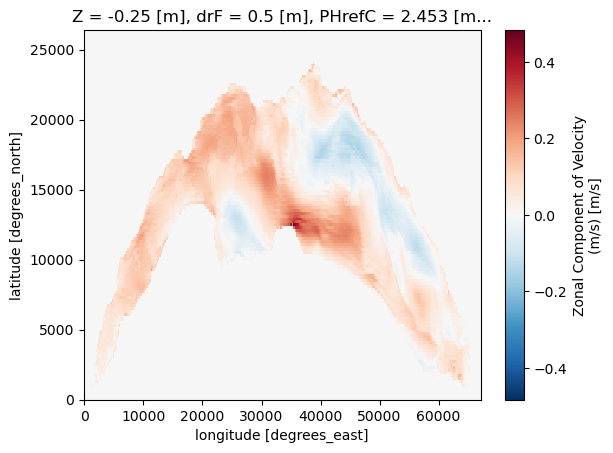

In [40]:
xr_mitgcm['UVEL'].isel(time=t_index, Z=z_index).plot()